In [1]:
import numpy as np
import scipy as sp
import math
import torch
import matplotlib.pyplot as plt
import inspect
import textwrap
import random
from tqdm import tqdm
import optuna
import functools
from sklearn.model_selection import KFold

from typing import Callable
from torch import nn, optim
from data import diffeq, create_trainig_test_set, create_trainig_validation_test_set

import torch.nn.functional as F

from ray import tune
from ray.tune.schedulers import ASHAScheduler
from functools import partial
import pickle
from pathlib import Path

In [2]:
#Define the harmonic oscillator

def f(t,x,k):
    #write the function that is on the other side of the differential equation
    return -k*x

def differential_equation_1_order(t, x, k):
    dx_dt = f(t,x,k)
    return dx_dt

def differential_equation_2_order(t, X, k):
    #rewrite d^2x/dt^2 as dy/dt where y=dx/dt
    x, y = X
    dx_dt = y
    dy_dt = f(t,x,k)

    return [dx_dt, dy_dt]

In [11]:
if torch.accelerator.is_available():
    device = torch.accelerator.current_accelerator().type
else:
    device = "cpu"
print(device)

cpu


# Hyperparameter optimization of the model

In [ ]:
torch.manual_seed(0) #get the same random numbers everytime you run the code
harmonic_osc = diffeq(differential_equation_2_order, 2, 1)

t_span = (0, 10)
n_step = 100
n_data = 1000
coeff_test = 0.3

train2, validation2, test2 = create_trainig_validation_test_set(harmonic_osc, (0, 10), 100, 1000, [0.5, 0.2, 0.3], "RK45", device=device, seed=0)

In [13]:
class HarmonicModel(nn.Module):
    def __init__(self, n_in, n_layers, n_neurons, activation):
        super().__init__()
        layers = []
        act = {
            'tanh': nn.Tanh(),
            'sine': torch.sin,
            'gelu': nn.GELU(),
            'relu': nn.ReLU()
        }[activation]
        
        layers.append(nn.Linear(n_in, n_neurons))
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(n_neurons, n_neurons))
        layers.append(nn.Linear(n_neurons, 1))
        
        self.layers = nn.ModuleList(layers)
        self.activation = act

    def forward(self, x):
        for layer in self.layers[:-1]:
            if callable(self.activation):  # sine special case
                x = self.activation(layer(x))
            else:
                x = self.activation(layer(x))
        return self.layers[-1](x)

# test model
model = HarmonicModel(4, 2, 32, 'tanh').to(device)

In [14]:
def loss_harmonic(y_pred, y_exp, x_00, x_01, t, k, N_f):
    mse_y = torch.mean((y_pred - y_exp)**2)

    return mse_y

In [15]:
def train_harmonic(model, lr, epochs, data):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    X = data["X"]
    y_exp = data["y_tensor"][0:, 0:, 0].to(device)

    for epoch in range(epochs):
        y_pred = model(X).squeeze(-1)
        t = X[0:, 0:, 3]
        k = X[0:, 0:, 0]
        x_00 = X[0:, 0:, 1]
        x_01 = X[0:, 0:, 2]
    
        loss = loss_harmonic(y_pred, y_exp, x_00, x_01, t, k, N_f=1000)
    
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
    
        if (epoch+1) % (int(epochs)) == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

    return loss.item()

In [16]:
def rng_hparameters_search(n_trials, layers_i: tuple, neurons_i: tuple, activations_l: list, data, seed=0, device='cpu'):
    torch.manual_seed(seed)
    random.seed(seed)
    result = []

    for _ in tqdm(range(n_trials), desc="Hyperparameter search"):
        n_layers = random.randint(layers_i[0], layers_i[1])  # inclusive
        n_neurons = random.randint(neurons_i[0], neurons_i[1])
        activation = random.choice(activations_l)

        params = {
            'n_layers': n_layers,
            'n_neurons': n_neurons,
            'activation': activation
        }

        model = HarmonicModel(4, n_layers, n_neurons, activation).to(device)
        final_loss = train_harmonic(model, lr=0.01, epochs=100, data=data)
        result.append((params, final_loss))
    
    return result


In [17]:
n_trials = 3
results = rng_hparameters_search(n_trials, (1, 10), (1, 100), ['tanh', 'sine', 'gelu', 'relu'], validation2, seed=0)

Hyperparameter search:  33%|███▎      | 1/3 [00:10<00:20, 10.19s/it]

Epoch 100/100, Loss: 0.8232


Hyperparameter search:  67%|██████▋   | 2/3 [00:10<00:04,  4.48s/it]

Epoch 100/100, Loss: 0.6376


Hyperparameter search: 100%|██████████| 3/3 [00:14<00:00,  4.70s/it]

Epoch 100/100, Loss: 0.1622


In [18]:
# Define your hyperparameter ranges and data
layers_i = (1, 10)
neurons_i = (4, 128)
activations_l = ['tanh', 'sine', 'gelu', 'relu']
data = validation2  # your dataset
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def objective(trial, layers_i, neurons_i, activations_l, data):
    n_layers = trial.suggest_int("n_layers", layers_i[0], layers_i[1])
    n_neurons = trial.suggest_int("n_neurons", neurons_i[0], neurons_i[1])
    activation = trial.suggest_categorical("activation", activations_l)

    model = HarmonicModel(4, n_layers, n_neurons, activation).to(device)
    final_loss = train_harmonic(model, lr=0.01, epochs=100, data=data)
    return final_loss

# Use functools.partial to pass extra arguments
objective_fixed = functools.partial(objective, layers_i=layers_i, neurons_i=neurons_i,
                                    activations_l=activations_l, data=data)

study = optuna.create_study(direction="minimize")
study.optimize(objective_fixed, n_trials=3)


[I 2025-12-03 15:09:12,920] A new study created in memory with name: no-name-b866cdd0-5e5a-4a44-9c5c-bc680d59c96c
[I 2025-12-03 15:09:13,676] Trial 0 finished with value: 0.33957505226135254 and parameters: {'n_layers': 10, 'n_neurons': 8, 'activation': 'relu'}. Best is trial 0 with value: 0.33957505226135254.


Epoch 100/100, Loss: 0.3396


[I 2025-12-03 15:09:19,014] Trial 1 finished with value: 0.27695927023887634 and parameters: {'n_layers': 7, 'n_neurons': 59, 'activation': 'relu'}. Best is trial 1 with value: 0.27695927023887634.


Epoch 100/100, Loss: 0.2770


[I 2025-12-03 15:09:40,292] Trial 2 finished with value: 0.7273523807525635 and parameters: {'n_layers': 9, 'n_neurons': 122, 'activation': 'gelu'}. Best is trial 1 with value: 0.27695927023887634.


Epoch 100/100, Loss: 0.7274


In [19]:
print("Best params:", study.best_params)
print("Best loss:", study.best_value)

Best params: {'n_layers': 7, 'n_neurons': 59, 'activation': 'relu'}
Best loss: 0.27695927023887634


In [20]:
best_params, best_loss = min(results, key=lambda x: x[1])
print("\nBest configuration:")
print(best_params)
print(f"Final loss: {best_loss:.3e}")


Best configuration:
{'n_layers': 7, 'n_neurons': 39, 'activation': 'relu'}
Final loss: 1.622e-01


# Test best hyperparameters

In [21]:
n_layers_opt_rand = best_params["n_layers"]
n_neurons_opt_rand = best_params["n_neurons"]
activation_opt_rand = best_params["activation"]

n_layers_opt_bayes = study.best_params["n_layers"]
n_neurons_opt_bayes = study.best_params["n_neurons"]
activation_opt_bayes = study.best_params["activation"]

model_optimized_rand = HarmonicModel(4, n_layers_opt_rand, n_neurons_opt_rand, activation_opt_rand).to(device)
model_optimized_bayes = HarmonicModel(4, n_layers_opt_bayes, n_neurons_opt_bayes, activation_opt_bayes).to(device)

In [22]:
# training
loss_last_rand= train_harmonic(model_optimized_rand, 0.01, 1000, train2)
loss_last_bayes = train_harmonic(model_optimized_bayes, 0.01, 1000, train2)

Epoch 1000/1000, Loss: 0.0247
Epoch 1000/1000, Loss: 0.0021


In [23]:
# test dataset random
model_optimized_rand.eval()
X = test2["X"]
y_exp = test2["y_tensor"][0:, 0:, 0].to(device)
y_pred_rand = model_optimized_rand(X).squeeze(-1)
t = X[0:, 0:, 3]
k = X[0:, 0:, 0]
x_00 = X[0:, 0:, 1]
x_01 = X[0:, 0:, 2]
test_loss_rand = loss_harmonic(y_pred_rand, y_exp, x_00, x_01, t, k, N_f=100)
print(f"Test Loss Random optimization: {test_loss_rand.item():.4f}")

# test dataset bayes
model_optimized_bayes.eval()
X = test2["X"]
y_exp = test2["y_tensor"][0:, 0:, 0].to(device)
y_pred_bayes = model_optimized_bayes(X).squeeze(-1)
t = X[0:, 0:, 3]
k = X[0:, 0:, 0]
x_00 = X[0:, 0:, 1]
x_01 = X[0:, 0:, 2]
test_loss_bayes = loss_harmonic(y_pred_bayes, y_exp, x_00, x_01, t, k, N_f=100)
print(f"Test Loss Random optimization: {test_loss_bayes.item():.4f}")

Test Loss Random optimization: 0.0449
Test Loss Random optimization: 0.0053


torch.Size([300, 100])
torch.Size([300, 100])


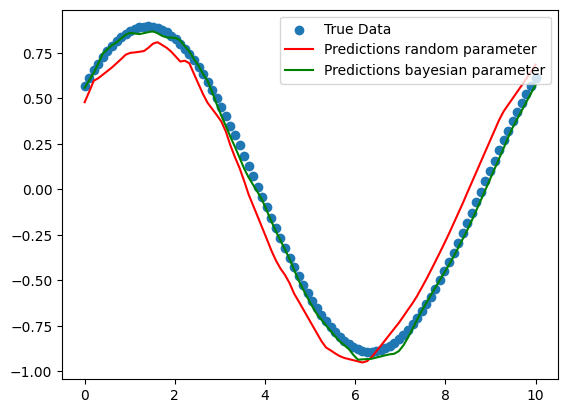

In [24]:
print(y_pred_rand.shape)
print(y_pred_bayes.shape)

y_pred_rand.to("cpu")
y_pred_bayes.to("cpu")
test2["t_tensor"].to("cpu")

n = 30
plt.scatter(test2["t_tensor"][n], test2["y_tensor"][n][0:, 0], label="True Data")
plt.plot(test2["t_tensor"][n], y_pred_rand.cpu().detach()[n], color="red", label="Predictions random parameter")
plt.plot(test2["t_tensor"][n], y_pred_bayes.cpu().detach()[n], color="green", label="Predictions bayesian parameter")
plt.legend()
plt.show()

In [25]:
K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=42)
fold_losses = []

for train_idx, val_idx in kf.split(data['args_tensor']):
    # Slice each tensor in the dictionary
    train_fold = {k: v[train_idx].to(device) for k, v in data.items()}
    val_fold   = {k: v[val_idx].to(device)   for k, v in data.items()}

    # Initialize model with best hyperparameters
    model = HarmonicModel(
        4,
        best_params['n_layers'],
        best_params['n_neurons'],
        best_params['activation']
    ).to(device)

    # Train model on this fold
    loss = train_harmonic(model, lr=0.01, epochs=100, data=(train_fold, val_fold))
    fold_losses.append(loss)

average_cv_loss = sum(fold_losses) / K
print("Estimated generalization loss (K-Fold CV):", average_cv_loss)


TypeError: tuple indices must be integers or slices, not str

# TO DO

- Finish K-fold validation
- Test data on noisy data (physical data)
- Test generalization of model